# Generate Heatmap from Multilabel Classification Model

pre-requisite: a saved DenseNet-121-attA model

In [1]:
import torch
from torch import sigmoid
from torch.nn import Linear
import torch.nn as nn
import torch.nn.init as nn_init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2
import os
from os import path
from sklearn.metrics import roc_auc_score
import datetime
import time

%matplotlib inline
path_join = path.join

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## User inputs

In [2]:
ALL_IMAGE_DIR = '/Users/marcustan/Data/ChestXray14/images'; # directory containing all images
BASE_PATH_LABELS = './labels'; # training, validation and test lists

TEST_LIST = ['test_A.csv']

MODEL_FILENAME = './models/sigmoid-lr0p01-densenet121attA-2021-05-01-15-55-07'
MODEL_NAME = 'densenet121attA'

CLASSES = ['No Finding', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
          'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

BATCH_SIZE = 4

SEED = 0

## Load images

In [3]:
path_join = path.join

# Set seed
np.random.seed(SEED)
torch.manual_seed(SEED)

CLASSES = np.array(CLASSES)
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, im_dir, im_names, im_labels, im_transforms=None):
        self.im_dir = im_dir
        self.im_labels = im_labels
        self.im_names = im_names
        if im_transforms:
            self.im_transforms = im_transforms
        else:
            self.im_transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        
        return len(self.im_labels)

    def __getitem__(self, idx):
        im_file = os.path.join(self.im_dir,
                               self.im_names[idx])
        #print(im_file)
        im = Image.open(im_file).convert('RGB')

        im = self.im_transforms(im)
        
        return im, self.im_labels[idx]

def load_data(all_image_dir, train_lists, base_path_labels, classes, batchsize, im_transforms, shuffle=True):
    train_sets = []
    train_loaders = []
    for train_list in train_lists:
        full_path_list = path_join(base_path_labels, train_list)
        df = pd.read_csv(full_path_list)
        im_names = df['Image'].to_numpy()
        im_labels = torch.tensor(df[classes].to_numpy(), dtype=torch.float)
        #assert im_labels.shape[1] == n_classes, 'Number of classes from train list not consistent with provided N_CLASSES'
        train_sets.append(CustomDataset(all_image_dir, im_names, im_labels, im_transforms))
        train_loaders.append(DataLoader(train_sets[-1], batch_size=batchsize, shuffle=shuffle))
        print('Size for {0} = {1}'.format(train_list, len(im_names)))
    
    return train_loaders, train_sets
    
# Load data

im_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

all_loaders, all_sets = load_data(ALL_IMAGE_DIR, TEST_LIST, BASE_PATH_LABELS, CLASSES, BATCH_SIZE, im_transforms, shuffle=False)


Size for test_A.csv = 6112


## Visualize some images

Visualize training images ...
Training set 0


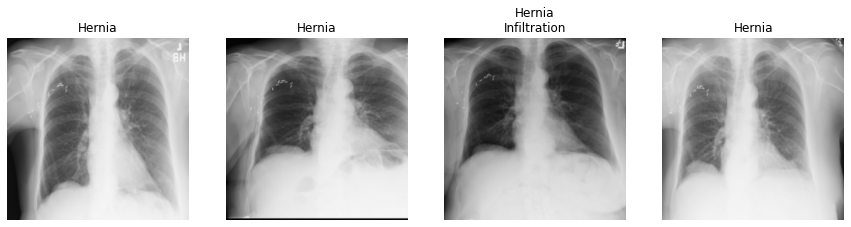

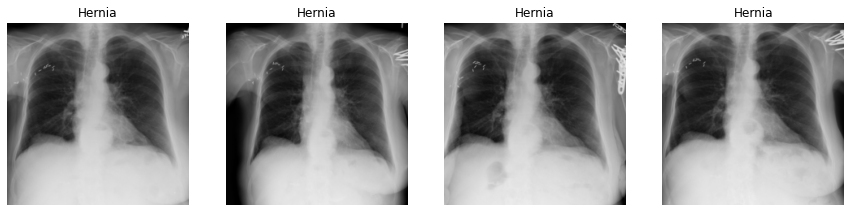

In [4]:
# Visualize some of the images and show corresponding labels
def show_batch_images(dataloader_iter, classes):
    images, labels = next(dataloader_iter)
    fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
    
    im_mean = torch.tensor([0.485, 0.456, 0.406])
    im_std = torch.tensor([0.229, 0.224, 0.225])
    
    
    for count, (im, label) in enumerate(zip(images, labels)):
        ax = axes[count]
        im = im.permute(1, 2, 0)
        # un-normalized the image
        im.mul_(im_std).add_(im_mean); # inplace multiplication and addition
        im = im.numpy()
        
        # The normalize code -> t.sub_(m).div_(s)
        ax.imshow(im, vmin=0, vmax=1)
        ax.axis('off')
        idx = label.nonzero().squeeze(1).numpy()
        if len(idx):
            class_names = classes[idx]
            title = '\n'.join(list(class_names))
        else:
            title = 'No Finding'

        ax.set_title(title)
        
        
print('Visualize training images ...')
for count, loader in enumerate(all_loaders):
    loader_iter = iter(loader)
    print('Training set {0}'.format(count))
    for i in range(2):
        show_batch_images(loader_iter, CLASSES)


<hr>

## Initialize and Load Model

In [5]:
import importlib

def initialize_model(model_name):
    if  'densenet121att' in model_name:
        model_module = importlib.import_module(model_name)
        #print(model_module)
        model = getattr(model_module, model_name)(pretrained=True, 
                                                  num_classes=len(CLASSES))
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)))
        # Do not add softmax or sigmoid
    else:
        raise NotImplementedError('Unknown model name')
    
    return model 

model = initialize_model(MODEL_NAME)
#print(model)


print('Model filename =', MODEL_FILENAME)

model.load_state_dict(torch.load(MODEL_FILENAME, map_location='cpu'))
model.to(device)

print('Successfully loaded model')


Model filename = ./models/sigmoid-lr0p01-densenet121attA-2021-05-01-15-55-07
Successfully loaded model


<hr>

# Generate Heat Map

y_hat = [1.0582838e-02 9.5759952e-01 8.4903685e-04 3.3047521e-01 1.0548482e-03
 4.1543865e-01 5.5517875e-02 1.4645389e-01 1.9784747e-02 6.9904635e-03
 6.4949682e-03 1.5205727e-02 5.8370051e-03 9.1153108e-02 1.0585176e-01]


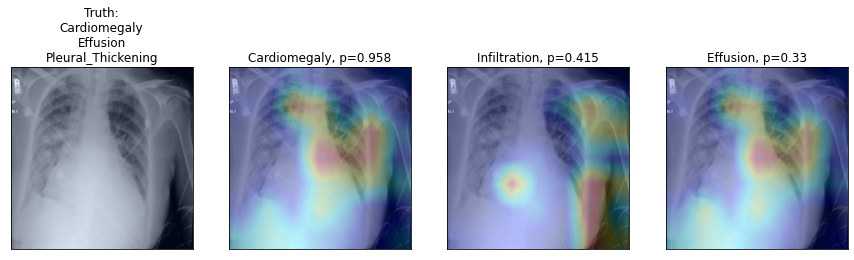

In [6]:
### User inputs ###
HEATMAP_MODE = 'A'
TARGET_SET = 0
#TARGET_IMAGE = 50; # Emphysema, Pneumothorax
#TARGET_IMAGE = 4; # Hernia
#TARGET_IMAGE = 200; # no finding
#TARGET_IMAGE = 10; # Emphysema
#TARGET_IMAGE = 11; # Emphysema
TARGET_IMAGE = 100; # Cardiomegaly

N_TOP = 3; # Get the first N_TOP labels with highest probabilities

SAVE_HEATMAP_NAME = './heatmaps/densenet121attA_heatmap_testA_img'+str(TARGET_IMAGE)

### End user inputs ###

# load target image and labels
target_image, target_label = all_sets[TARGET_SET][TARGET_IMAGE]
img_original = target_image.permute(1, 2, 0)
# add batch dimension
target_image = target_image.view(1, target_image.shape[0], target_image.shape[1], target_image.shape[2])

# calculate class probabilities
model.eval()
y_hat = model(target_image.to(device)).sigmoid().detach().numpy().squeeze()
print('y_hat =', y_hat)

# sort class from highest to lowest probability
sorted_idx = (-y_hat).argsort()
sorted_idx = sorted_idx[:N_TOP]

# Get the N_TOP most probable classes
pred_class_names = CLASSES[sorted_idx]
#pred_label_names = '\n'.join(list(pred_class_names))
top_prob = y_hat[sorted_idx]

# Plot the original image with ground truths
fig, axes = plt.subplots(1, N_TOP+1, figsize=(15, 7))
ax = axes[0]

# un-normalized the image
#im_mean = torch.tensor([0.485, 0.456, 0.406])
#im_std = torch.tensor([0.229, 0.224, 0.225])
#img_original.mul_(im_std).add_(im_mean); # inplace multiplication and addition
img_original = img_original.numpy()
img_original = (img_original - np.min(img_original)) / (np.max(img_original) - np.min(img_original))
        
ax.imshow(img_original)
idx = target_label.nonzero().squeeze(1).numpy()
class_names = CLASSES[idx]
label_names = '\n'.join(list(class_names))

title = 'Truth:\n' + label_names
ax.set_title(title)
ax.set_xticks([])
ax.set_yticks([])

# calculate the heat maps for each of the N_TOP most probable classes
for ii in range(N_TOP):
    most_prob_class = sorted_idx[ii]
    model.eval()
    y_hat, A, l1, l2, l3, grad_A, grad_l1, grad_l2, grad_l3, img_heatmap, img_original, img_result = model.generate_heatmap(target_image.to(device), 
                                                                   most_prob_class,
                                                                    HEATMAP_MODE)

    ax = axes[ii+1]
    ax.imshow(img_result)
    title = pred_class_names[ii] + ', p=' + str(round(top_prob[ii],3))
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig(SAVE_HEATMAP_NAME, bbox_inches='tight')

#CLASSES = ['No Finding', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
#          'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']